# Project 1 - Lane Detection
### Joseph Voyles
#### December 6th, 2016

# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline
# Import everything needed to edit/save/watch video clips
#from moviepy.editor import VideoFileClip
#from IPython.display import HTML

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def calcAngle(x2,x1,y2,y1):
    try:
        return float(x2-x1)/float(y2-y1)
    except:
        return 0


def draw_lines(img, lines,apex,imshape,color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """    
    leftLines = np.empty(lines[0].shape)
    rightLines = np.empty(lines[0].shape)
    

    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            if calcAngle(x2,x1,y2,y1) == 0:
                pass
            elif calcAngle(x2,x1,y2,y1) <0:
                
                leftLines = np.concatenate((leftLines,line),axis=0)
            else:
                rightLines = np.append(rightLines,line,axis=0)
    
    try:
        #extrapolate the left line
        leftLines_cp = remove_noise_lines(leftLines, (300, 400),.5)
        if leftLines_cp.size>0:
            avgLeft = np.mean(leftLines_cp,axis=0)

            m_left =  (avgLeft[3]-[avgLeft[1]])/(avgLeft[2]-[avgLeft[0]])
            b_left = avgLeft[1]-(m_left*avgLeft[0])
            minX_left = float((imshape[0]-b_left)/m_left)
            maxX_left = float((apex-b_left)/m_left)

            cv2.line(img,(int(maxX_left),apex),(int(minX_left),imshape[0]),color,thickness)
        else:
            avgLeft = np.mean(np.delete(leftLines,0,axis=0),axis=0)
        
            m_left =  (avgLeft[3]-[avgLeft[1]])/(avgLeft[2]-[avgLeft[0]])
            b_left = avgLeft[1]-(m_left*avgLeft[0])
            minX_left = float((imshape[0]-b_left)/m_left)
            maxX_left = float((apex-b_left)/m_left)

            cv2.line(img,(int(maxX_left),apex),(int(minX_left),imshape[0]),color,thickness)
            
    except:
        pass
    try:
        # extrapolate the right line
        rightLines_cp = remove_noise_lines(rightLines, (500, 700),.2)
        if rightLines_cp.size>0:
            avgRight = np.mean(rightLines_cp,axis=0)
            m_right =  (avgRight[3]-[avgRight[1]])/(avgRight[2]-[avgRight[0]])
            b_right = avgRight[1]-(m_right*avgRight[0])
            minX_right = float((imshape[0]-b_right)/m_right)
            maxX_right = float((apex-b_right)/m_right)
            cv2.line(img,(int(maxX_right),apex),(int(minX_right),int(imshape[0])),color,thickness)
        else:
            avgRight = np.mean(np.delete(rightLines,0,axis=0),axis=0)
            m_right =  (avgRight[3]-[avgRight[1]])/(avgRight[2]-[avgRight[0]])
            b_right = avgRight[1]-(m_right*avgRight[0])
            minX_right = float((imshape[0]-b_right)/m_right)
            maxX_right = float((apex-b_right)/m_right)
            cv2.line(img,(int(maxX_right),apex),(int(minX_right),int(imshape[0])),color,thickness)
    except:
        pass
    return img

def hough_lines(img, sourceImage, rho, theta, threshold, min_line_len, max_line_gap,apex):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.copy(sourceImage)*0
    line_img = draw_lines(line_img, lines,apex,img.shape,thickness=10)
    return  line_img

# Python 3 has support for cool math symbols.

def weighted_img(img,initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

# This function is a slightly modified code from a comment on the class forum by U'Alaa Abuzaghleh
# the comment and code can be found here -> https://carnd-udacity.atlassian.net/wiki/display/CAR/questions/22086201/p1-how-to-avoid-jittery-lines
def remove_noise_lines(lines_arr, cut_val, thresh=0.08):
    lines_arr = np.array(lines_arr)
    
    lines_arr = lines_arr[(lines_arr[:, 2] >= cut_val[0]) & (lines_arr[:, 2] <= cut_val[1])]
    mean_of_end_pts = np.mean(lines_arr[:, 2], axis=0)
    
    min_v = mean_of_end_pts-(mean_of_end_pts*thresh)
    max_v = mean_of_end_pts+(mean_of_end_pts*thresh)
    return lines_arr[(lines_arr[:, 2] <= max_v) & (lines_arr[:, 2] >= min_v)]

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

(540, 960, 3)


/home/joseph/py3_kernel/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/joseph/py3_kernel/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


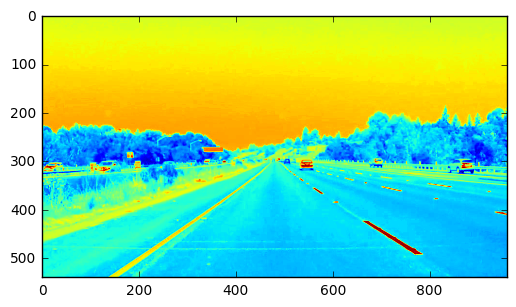

In [10]:
# select an image 0 -5
imageIndex = 0
images = os.listdir("test_images/")
image = mpimg.imread("./test_images/"+images[imageIndex])
print(image.shape)
if("processed_images" not in os.listdir()):
    os.mkdir("processed_images/")
cv2.imwrite("./processed_images/"+images[imageIndex],process_image(image))
plt.imshow(grayscale(image))

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    red_threshold = 195
    green_threshold  = 180
    blue_threshold = 85

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    color_select = np.copy(image)


    # filter out all objects that are darker than the yellow lane
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    gray = grayscale(color_select)

    # apply gaussian transform and edge detections
    kernel_size = 3
    blur_gray = gaussian_blur(gray,kernel_size)

    # apply edge detection
    low_threshold = 45
    high_threshold = 180
    edges = canny(blur_gray, low_threshold, high_threshold)

    # apply a mask to focus only on the section of interest
    mask = np.zeros_like(gray)   
    ignore_mask_color = 255  

    imshape = image.shape
    apex = 330
    vertices = np.array([[(100,imshape[0]),(450, apex), (490, apex), (imshape[1],imshape[0])]], dtype=np.int32)
    #cv2.fillPoly(mask, vertices, ignore_mask_color)
    #cv2.bitwise_and(edges, mask)
    masked_edges = region_of_interest(edges,vertices)
    
    # Run Hough on edge detected image
    rho =2
    theta = (np.pi/180)*1
    threshold =40
    min_line_len = 15
    max_line_gap = 20
    #line_image = np.copy(image)*0 #creating a blank to draw lines o
    #cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

    line_image = hough_lines(masked_edges,image, rho, theta, threshold, min_line_len, max_line_gap,apex)
    #plt.show(line_image)
    # Draw the lines on the edge image
    combo = weighted_img(line_image, image, 0.8, 1,0)

    return combo

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
#plt.imshow(white_clip)
#white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:11<00:00, 14.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.53 s, sys: 1.18 s, total: 7.71 s
Wall time: 13.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="750" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:44<00:00, 16.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 25 s, sys: 5.34 s, total: 30.3 s
Wall time: 46.6 s


In [12]:
HTML("""
<video width="750" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

#### Algorithm Improvements
The current processing pipeline utilizes canny edge detection and hough transform to pick up line segments. The image is preprocessed by selecting only colors that are lighter than the yellow lane marker which also picks up the white lines. After this fitler, blurring is applied for noise reduction and the image is masked to focus on just the lanes.

The algorithm exhibits several behaviors that could be improved. Specifically, drawn lines are not steady and appear to be jumping around due to noise in the left and right identified lines that impacts the average line slope. This issue seems to be caused by lines that are either missclassified as a right or left line or a line that has been identified with a slope that is extreme (i.e. the hough transform identifies lines that are not part of the lane marker).

I have tried removing some of this noise with advice from the forums, but it is not perfect and sometimes prodcuces a frame where one or both of the lines are missing. The noise reduction is achieved by filtering out lines that do not fit within a defined range along the x axis. This removes any lines that will produce a slope large enough to throw off the average.

All model paramters could be further tuned to improve on this issue and would probably required an indepth exploration of the frames where the line detection picks up additional lines. Further noise removal could also be performed by looking at line slopes (e.g. filter out lines with slopes that approach 0) instead of using my current approach which just filters out lines based on their x coordinates. Finally, an additional feature could be added to remember prior lines and mix the t-1 line with the current. This would limit the extreme variations that are sometimes encountered from frame to frame.

#### Where will it fail?
The current algorithm will likely struggle in situations where lines unrelated to lane markers appear within the masked region. This could be anything from an object in the road, lane labels, or objects that appear on the periphery of the masked region.

After running the algo against the challenge video, it is clear that this model will struggle with roads that curve. The problem appears to be with lines that are identified along the horizon that curve in a direction that is opposite of the slope of the lane lines. To correct for this issue, curved lines would need to be detected. Once detected and assigned to the left or right lane markers, the lines would need to be extrapolated taking into consideration the curve of the line. 



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [59]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



100%|██████████| 251/251 [00:48<00:00,  5.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 20.3 s, sys: 2.08 s, total: 22.3 s
Wall time: 52.5 s


In [60]:
HTML("""
<video width="750" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))